# Prelude

Numerical optimization is a big topic, and this week will cover only a few basics.  If you're intrigued enough to dig into a textbook after this, there are a few from my own shelf that I recommend:

- [*Numerical Optimization*, Nocedal and Wright](https://link.springer.com/book/10.1007/978-0-387-40065-5)
- [*Practical Optimization*, Gill, Murray, and Wright](https://doi.org/10.1137/1.9781611975604)
- [*Nonlinear Programming*, Bertsekas](http://www.athenasc.com/nonlinbook.html)

These notes are also partly adapted from a numerical analysis course that I teach that covers some numerical linear algebra, nonlinear equation solving, and optimization.  The notes (and notebooks) for the most recent offering are publicly available [here](https://www.cs.cornell.edu/courses/cs4220/2020sp/schedule.html).

# Unconstrained optimization (part 1)

In [1]:
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
import scipy.optimize
import matplotlib.pyplot as plt

## Basic setup

We consider the optimization problem:
$$
  \min_{x \in \Omega} \phi(x)
$$
The function $\phi$ is often called the objective or the cost function.
For today, we simplify by just considering 

- Continuous problems ($\Omega \subset \mathbb{R}^n$)
- Smooth objectives ($\phi \in C^2(\Omega)$)
- Unconstrained continuous problems ($\Omega = \mathbb{R}^n$)

Even with these simplifications, optimization problems can be very hard.  To see some of the types of challenges optimization algorithms can face, it is worth perusing the collections of test problems people have assembled (the [Wikipedia page](https://en.wikipedia.org/wiki/Test_functions_for_optimization) has some links and pictures).
In general, finding a *global* minimum can be very hard even with smooth objectives, so we will focus on 
methods to find *local* minima; that is, we want $x_*$ such that $\phi(x_*) \leq \phi(x)$ for all $x$ close
enough to $x_*$.

By restricting ourselves in this way, we are able to use standard calculus tools to reason about optimization.  We can characterize extrema by the first derivative test (finding *stationary points* such that $\nabla \phi = 0$), and we classify at lesat some optima using the second derivative test based on the Hessian matrix $H_{\phi}$.  Calculus also gives us a lot of tools for reasoning about sensitivity to perturbations and doing local search.  The theme for today is algorithms that use a Taylor series expansion to model the objective locally, and make progress that way; tomorrow we will talk about methods that model the function by a least squares problem, or by an interpolating function instead of a Taylor expansion.

In general, the more structure we have, the easier the problems are to solve numerically -- or, at least, the easier it is to analyze solution algorithms.  For example, for *convex* problems, every local minimizer is also a global minimizer, and we can generally find algorithms to converge to some minimizer.

## Some model problems

It is always useful to look at methods in the context of some concrete model problems.  Let's consider three such problems: a simple quadratic in 2D, a standard 2D model problem (the McCormick function), and a discretized reaction-diffusion potential function.

### A quadratic model

A general quadratic function from $\mathbb{R}^n$ to $\mathbb{R}$ looks like
$$
  \phi(x) = c + b^T x + \frac{1}{2} x^T A x
$$
where $c \in \mathbb{R}$, $b \in \mathbb{R}^n$, and $A \in \mathbb{R}^{n \times n}$ with $A$ symmetric.
The gradient is $\nabla \phi(x) = b + Ax$ and the Hessian is $A$.  Assuming that $A$ is nonsingular, there is exactly one stationary point (point $x_*$  where $\nabla \phi(x_*) = 0$), which we find by solving the linear system $Ax = -b$.
If $A$ is positive definite, then $x_*$ is the unique global minimizer; if $A$ is negative definite, it is the maximizer; and if $A$ has both positive and negative eigenvalues, there is a saddle.

For our example problem, we set $c$ and $b$ to zero, and make $A$ diagonal:
$$
  A = \begin{bmatrix} 1 & 0 \\ 0 & 1000 \end{bmatrix}
$$

In [2]:
def phi_quadratic(x):
    "Simple quadratic test function"
    return 0.5 * (x[0]**2 + 1e3 * x[1]**2)

def phi_quadratic_xy(x, y):
    "Alternate form of phi_quadratic taking two args"
    return 0.5 * (x**2 + 1e3 * y**2)

def dphi_quadratic(x):
    "Gradient of the quadratic test function"
    return np.array([x[0], 1e3*x[1]])

def Hphi_quadratic(x):
    "Hessian of the quadratic test function"
    return np.array([[1.0, 0.0], [0.0, 1e3]])

A contour plot shows that there is a long, narrow valley: the function changes very rapidly with changes in $y$ relative to the variation with changes in $x$.

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9799fe6438>)

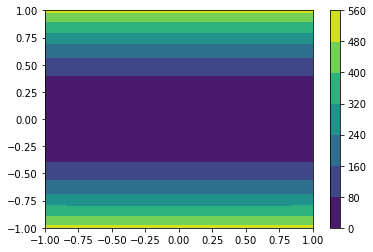

In [3]:
def plot_quadratic():
    "Draw a filled contour plot of phi_quadratic"
    xx = np.linspace(-1, 1)
    X, Y = np.meshgrid(xx, xx)
    Z = phi_quadratic_xy(xx[None,:], xx[:,None])
    fig,ax = plt.subplots(1,1)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp)
    return fig, ax

plot_quadratic()

The condition number of the symmetric matrix $A$ is
$$
  \kappa(A) = |\lambda_{\max}(A) / \lambda_{\min}(A)|;
$$
this measures how long and narrow the valley is, and is important to both sensitivity of the problem and convergence properties of numerical methods.  In this case, the condition number is 1000.

In [4]:
np.linalg.cond(Hphi_quadratic([0, 0]))

1000.0

### The McCormick function

The McCormick function is
$$
  \phi(x, y) = \sin(x+y) + (x-y)^2 - 1.5x + 2.5y + 1.
$$
This function has a global minimum at around $(-0.54719, -1.54719)$, but there many local optima.

The gradient and Hessian are also easy to compute, but if we are rusty on our calculus, we can also use the SymPy package to help us do the symbolic differentiation (uncomment the block below to see this in action).

In [5]:
## Demonstrate derivative computation with SymPy
import sympy
sympy.init_printing()
x, y = sympy.symbols('x y')
phi_mccormick_sym = sympy.sin(x+y) + (x-y)**2 - 1.5*x + 2.5*y + 1
print("[{0}\n {1}]".format(sympy.diff(phi_mccormick_sym, x), sympy.diff(phi_mccormick_sym, y)))
print("[[{0}, {1}],\n [{1}, {2}]]".format(\
    sympy.diff(phi_mccormick_sym, x, x), sympy.diff(phi_mccormick_sym, x, y), sympy.diff(phi_mccormick_sym, y, y)))

[2*x - 2*y + cos(x + y) - 1.5
 -2*x + 2*y + cos(x + y) + 2.5]
[[2 - sin(x + y), -(sin(x + y) + 2)],
 [-(sin(x + y) + 2), 2 - sin(x + y)]]


In [6]:
def phi_mccormick(x):
    "McCormick 2D test problem"
    return np.sin(x[0]+x[1]) + (x[0]-x[1])**2 - 1.5*x[0] + 2.5*x[1] + 1.0

def phi_mccormick_xy(x, y):
    return phi_mccormick((x, y))

def dphi_mccormick(x):
    "Gradient of McCormick test problem"
    return np.array([2*x[0] - 2*x[1] + np.cos(x[0]+x[1]) - 1.5,
                     -2*x[0] + 2*x[1] + np.cos(x[0]+x[1]) + 2.5])

def Hphi_mccormick(x):
    "Hessian of McCormick test problem"
    return np.array([[2 - np.sin(x[0]+x[1]), -(np.sin(x[0]+x[1]) + 2)],
                     [-(np.sin(x[0]+x[1]) + 2), 2 - np.sin(x[0]+x[1])]])

xref_mccormick = np.array([-0.54719, -1.54719])

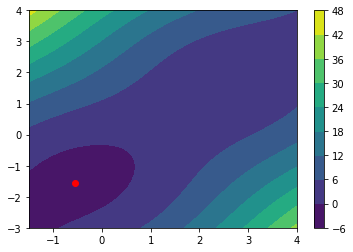

In [7]:
def plot_mccormick():
    "Draw a contour plot of the McCormick function on [-1.5,4]x[-3,4]"
    xx = np.linspace(-1.5, 4)
    yy = np.linspace(-3, 4)
    X, Y = np.meshgrid(xx, yy)
    Z = phi_mccormick_xy(xx[None,:], yy[:,None])
    fig,ax = plt.subplots(1,1)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp)
    return fig, ax

# Draw a plot and mark the reference location of the minimum
fig, ax = plot_mccormick()
ax.plot(xref_mccormick[0], xref_mccormick[1], 'ro')

### A reaction-diffusion example

The *Bratu equation* is a classic 1D PDE model from combustion theory:
$$\begin{align*}
  -\frac{d^2 u}{dx^2} - \lambda \exp(u) &= 0 \\
  u(0) = u(1) &= 0
\end{align*}$$
Solutions to the PDE correspond to stationary points of the functional:
$$
  \psi[u] = \int_{0}^1 \left( \frac{1}{2} u'(x)^2 - \lambda \exp(u) \right) \, du
$$
over the space of functions with $L^2$ derivatives satisfying the Dirichlet boundary conditions.  Stable solutions to an associated time-domain problem correspond to minimizers.

We cannot compute with infinite-dimensional objects like functions and shapes, so we must discretize.  A simple way to discretize is to let $u$ be piecewise linear on a mesh with breakpoints $x_0, \ldots, x_{N+1}$ with $x_k = kh = k/(N+1)$, and to represent $u$ by the function values at those mesh points.  With some calculus, we then have the discrete function
$$
  \hat{\psi}(u) = h \sum_{k=1}^{N+1} \left[ 
    \frac{1}{2} \left(\frac{u_k-u_{k-1}}{h}\right)^2 -
    \frac{\lambda}{u_k-u_{k-1}} \left(\exp(u_k)-\exp(u_{k-1})\right) \right].
$$
We can approximate the latter term in the sum by $\lambda \exp(u_k)$ (up to an $O(h)$ overall error) to get the objective function
$$
  \phi(u) = h \sum_{k=1}^{N+1} \left[
    \frac{1}{2} \left(\frac{u_k-u_{k-1}}{h}\right)^2 -
    \lambda \exp(u_k) \right].
$$
For $k = 1, \ldots, N$, we have
$$
  \frac{\partial \phi}{\partial u_k} = h \left[ \frac{-u_{k-1} + 2u_k - u_{k+1}}{h^2} - \lambda \exp(u_k) \right]
$$
setting these derivatives equal to zero gives the standard centered finite difference discretization of the Bratu equation.

In [8]:
def phi_bratu(u, lam=1.0):
    "Compute the Bratu functional for u on a uniform mesh (u to include values at 0, 1)"
    phi = 0.0
    h = 1.0 / (u.shape[0]-1)
    for k in range(1, u.shape[0]):
        phi += 0.5/h * (u[k]-u[k-1])**2 - lam*h * np.exp(u[k])
    return phi

def dphi_bratu(u, lam=1.0):
    "Gradient of phi_bratu (input on N+2 nodes, output on N)"
    h = 1.0 / (u.shape[0]-1)
    return (-u[0:-2] + 2*u[1:-1] - u[2:])/h - lam*h*np.exp(u[1:-1])

def Hphi_bratu(u, lam=1.0):
    "Sparse Hessian of phi_bratu (input on N+2 nodes, output of N-by-N)"
    N = u.shape[0]-2
    h = 1.0 / (N+1)
    Hdiags = np.zeros((3, N))
    Hdiags[0,:] = -1.0/h
    Hdiags[1,:] =  2.0/h - lam*h*np.exp(u[1:-1])
    Hdiags[2,:] = -1.0/h
    return scipy.sparse.spdiags(Hdiags, [-1, 0, 1], N, N, format='csc')

The Bratu problem is nominally infinite-dimensional, but in practice the solution is smooth enough that it can be described quite well with a low-degree polynomial.  A not-completely-terrible approximation to the solution (at least when $\lambda$ is not large) is
$$
  u(x) \approx 4 u_{mid} x(1-x),
$$
for some unknown center value $u_{mid}$; and a reasonable way to estimate the behavior is to plot the function just in this direction.  Let's take advantage of this by defining a single-variable version of the Bratu optimization that only involves finding $u_{mid}$.

Minimum at umid = 0.14 (phi' = 0.0006594469698151671, phi'' = 4.731711221334596)
Maximum at umid = 4.01 (phi' = -0.00241420950271979, phi'' = -14.112740859879247)


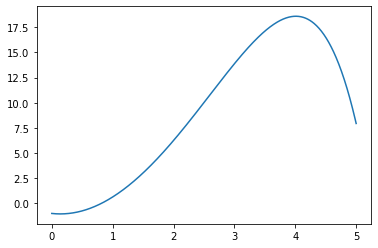

In [9]:
bratu_xx = np.linspace(0.0, 1.0, 202)
bratu_vxx = 4 * bratu_xx * (1-bratu_xx)

def phi_bratu_1d(umid, lam=1.0):
    "Evaluate the Bratu potential function for a quadratic with value umid at x = 0.5"
    return phi_bratu(umid * bratu_vxx, lam=lam)

def dphi_bratu_1d(umid, lam=1.0):
    "Evaluate the derivative of phi_bratu_1d."
    return np.dot(dphi_bratu(umid * bratu_vxx, lam=lam), bratu_vxx[1:-1])

def Hphi_bratu_1d(umid, lam=1.0):
    "Evaluate the second derivative of phi_bratu_1d."
    return np.dot(bratu_vxx[1:-1], Hphi_bratu(umid * bratu_vxx, lam=lam) * bratu_vxx[1:-1])

umids = np.linspace(0, 5, 1001)
phis = np.array([phi_bratu_1d(umid) for umid in umids])
umids_min = umids[np.argmin(phis)]
umids_max = umids[np.argmax(phis)]
print("Minimum at umid = {0} (phi' = {1}, phi'' = {2})".format(\
      umids_min, dphi_bratu_1d(umids_min), Hphi_bratu_1d(umids_min)))
print("Maximum at umid = {0} (phi' = {1}, phi'' = {2})".format(\
      umids_max, dphi_bratu_1d(umids_max), Hphi_bratu_1d(umids_max)))
plt.plot(umids, phis)

## Simple gradient descent

One of the simplest optimization algorithm is gradient descent (aka steepest descent):
$$
  x_{k+1} = x_k - \alpha_k \nabla \phi(x_k)
$$
where $\alpha_k$ is a step size parameter.  Gradient descent is motivated by a first-order Taylor approximation
$$
  \phi(x_{k+1}) \approx \phi(x_k) + \nabla \phi(x_k)^T (x_{k+1}-x_k) = \phi(x_k) - \alpha_k \|\nabla \phi(x_k)\|^2.
$$
For sufficiently small $\alpha$, gradient descent will usually make slow but steady progress, improving the function value at each step.  But when we look in detail at what is meant by "sufficiently small" $\alpha$ and "slow but steady" progress, the basic method may be unattractive.  Let us consider, for example, the quadratic problem
$$
  \phi(x) = c + b^T x + \frac{1}{2} x^T A x.
$$
With a fixed step size $\alpha$, the gradient descent iteration is
$$
  x_{k+1} = x_k - \alpha (Ax_k + b) = (I-\alpha A) x_k + b,
$$
and we can subtract off the stationary equation $x_* = (I-\alpha A) x_* + b$ to get an *error iteration* for $e_k = x_k-x_*$:
$$
  e_{k+1} = (I-\alpha A) e_k.
$$
Assuming $A$ is positive definite, the iteration converges to the unique minimum $x_*$ if $\alpha < 1/\lambda_{\max}$, where $\lambda_{\max}$ is the largest eigenvalue of $A$.  The optimal $\alpha$ turns out to be
$$
  \alpha_* = \frac{2}{\lambda_{\min} + \lambda_{\max}},
$$
which gives a worst-case error decay rate of a factor of
$$
  \|e_{k+1}\| \leq \left\| 1 - \frac{2}{1 + \kappa(A)} \right\| \|e_k\|,
$$
where $\kappa(A)$ is the condition number described above (the ratio of the largest to the smallest eigenvalue).  This type
of convergence, where the error is cut by a constant factor at each step, is generally known as *linear* convergence.

Let's see how this plays out concretely for our quadratic model problem.

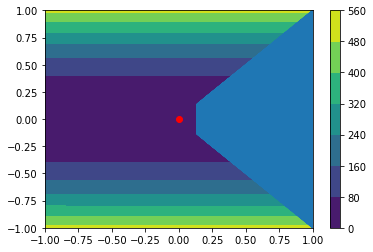

In [10]:
x = np.array([1.0, 1.0])
alpha_opt = 2.0/1001
xs = []
ys = []
errs = []

for k in range(1000):
    xs.append(x[0])
    ys.append(x[1])
    errs.append(np.linalg.norm(x))
    x = x - alpha_opt * dphi_quadratic(x)

plot_quadratic()
plt.plot(xs, ys)
plt.plot(0, 0, 'ro')

Text(0, 0.5, 'Error at step k')

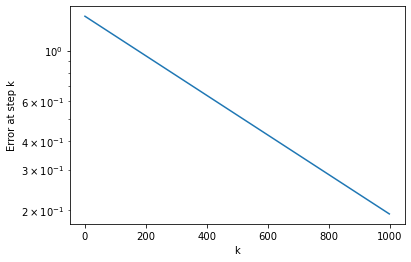

In [11]:
plt.plot(errs)
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("Error at step k")

In the long run, simple gradient descent converges on this problem when the steps are small enough.  Of course, in the long run we are all dead.  I will ask you to take my word that the Bratu problem has a similar pathology, for the same reason of poor conditioning.  Gradient descent typically only works really well for methods that are well scaled, particularly when gradients are cheap.  Clever methods that adapt the step size (e.g. the Barzilai-Borwein method) can help gradient descent converge more rapidly on a wider class of problems, but one still usually gets the best mileage from methods that choose a smarter step.  The prototypical example is the Newton iteration.

## Simple Newton

The fact that gradient descent behaves so poorly on a quadratic is particularly frustrating given that we can find the minimizer for a quadratic in closed form -- it is a simple matter of linear algebra.  If the quadratic is
$$
  \phi(x) = c + b^T x + \frac{1}{2} x^T A x,
$$
then the stationary point satisfies $\nabla \phi(x_*) = Ax_* + b = 0$, i.e. $x_* = -A^{-1} b$.  When $A$ is positive definite, as is true of $\phi$ has a (strong) minimizer, then we can solve the linear system by Cholesky factorization of the $A$ matrix followed by two triangular solves (forward and backward substitution).  The total cost is $O(n^3)$ if $A$ has no particular structure, but we might be able to do the linear algebra faster if there is some structure.

Where gradient descent makes progress by approximating the objective locally by a linear function, Newton iteration makes progress with a local quadratic approximation:
$$
  \phi(x_{k} + u) \approx \phi(x_k) + \nabla \phi(x_k)^T u + \frac{1}{2} u^T H_{\phi}(x_k) u
$$
The algorithm iteratively approximates $\phi$ by a quadratic Taylor series, then minimizes the quadratic; this gives
$$
  x_{k+1} = x_k - H_{\phi}(x_k)^{-1} \nabla \phi(x_k).
$$
Where gradient descent has *linear* convergence ($\|e_{k+1}\| \approx \rho \|e_k\|$ for some $\rho < 1$), under mild conditions the Newton iteration has local *quadratic* convergence, i.e. $\|e_{k+1}\| \approx C \|e_k\|^2$.  For a linear problem, of course, Newton converges in a single step.  For nonlinear problems, Newton may take only a couple steps to converge from a good initial guess.  For the Bratu problem, for example, it only takes three iterations to reach machine precision from the quadratic
initial guess described above.

Text(0, 0.5, 'Gradient norm at step k')

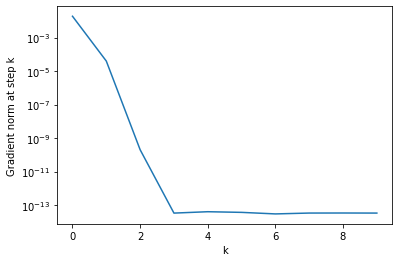

In [12]:
# Demo: Solve Bratu via Newton iteration
u = 0.1 * bratu_vxx
resids = []
for k in range(10):
    dphi_u = dphi_bratu(u)
    resids.append(np.linalg.norm(dphi_u))
    u[1:-1] -= scipy.sparse.linalg.spsolve(Hphi_bratu(u), dphi_u)

plt.plot(resids)
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("Gradient norm at step k")

(202,)


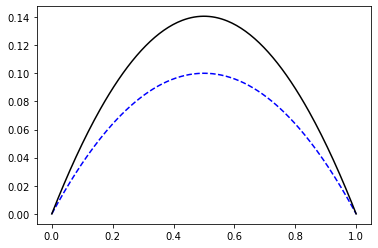

In [13]:
print(bratu_xx.shape)
plt.plot(bratu_xx, 0.1 * bratu_vxx, 'b--', bratu_xx, u, 'k-')

What happens with a sloppier initial guess?  Let's consider the McCormick function and plot what Newton iteration does from a starting point of $(1, -1.5)$.

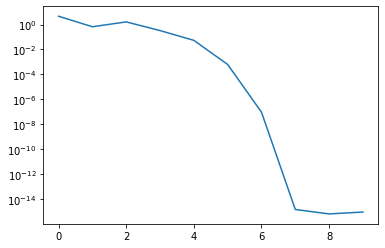

In [14]:
x = np.array([1.0, -1.5])
resids = []
for k in range(10):
    dphi_x = dphi_mccormick(x)
    resids.append(np.linalg.norm(dphi_x))
    x -= np.linalg.solve(Hphi_mccormick(x), dphi_x)

plt.plot(resids)
plt.yscale("log")

Convergence is pretty fast once it sets in, but it now takes a few steps.  Also, we do not land on the desired point!

In [15]:
print(x)
print(np.linalg.eig(Hphi_mccormick(x)))

[-1.5943951 -2.5943951]
(array([ 4.        , -1.73205081]), array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]]))


So: Newton sets a high standard for fast convergence, but it has some drawbacks:

- It requires lots of derivatives, and these may be a pain to derive
- In the high-dimensional case, forming and solving systems with the Hessian matrix can be expensive
- It can converge to a local max or saddle rather than a minimimum
- Convergence is only local, and may require a very good initial guess

We will spend the next few minutes discusssing alternative approaches that deal with these problems.

## Scaled gradient descent and Newton

The difference between the gradient descent iteration
$$
  x_{k+1} = x_k - \alpha \nabla \phi(x_k)
$$
and the Newton iteration
$$
  x_{k+1} = x_k - H_{\phi}(x_k)^{-1} \nabla \phi(x_k)
$$
lies only in how we scale the gradient direction.  We can more generally consider steps of the form
$$
  x_{k+1} = x_k - \alpha_k M_k^{-1} \nabla \phi(x_k)
$$
where $\alpha_k$ is a step size and $M_k$ is a *scaling matrix*.  For $M_k = I$, we have gradient descent;
for $M_k = H_{\phi}(x_k)$, we have Newton.

If $M_k$ is positive definite, then we can guarantee that we are at least moving in a *descent direction*; that is, Taylor's theorem gives
$$
  \phi(x_{k+1}) = \phi(x_k) - \alpha \nabla \phi(x_k)^T M_k^{-1} \nabla \phi(x_k) + O(\alpha^2)
$$
and $\nabla \phi(x_k)^T M_k^{-1} \nabla \phi(x_k) > 0$ for $\nabla \phi(x_k) \neq 0$ by positive definiteness.  Therefore, Newton methods for optimization typically use $M_k = H_{\phi}(x_k)$ when the Hessian is sufficiently positive definite, and otherwise modify the Hessian (e.g. using $M_k = H_{\phi}(x_k) + \lambda I$ for some $\lambda$ sufficiently large).

The scaled gradient descent framework also gives us a lot of flexibility to do things that are cheaper than taking a Newton step, or don't require as many derivatives.  For example, chord iterations "freeze" a Hessian for several steps, and othere methods that simply use an application-dependent scaling matrix that is not the same as the Hessian.  For the Bratu problem, simple gradient descent is extremely slow, but a simple scaling with the discrete Laplacian works reasonably well.

In [16]:
# Demo: Scaled gradient descent on 1D Bratu

u = 0.1 * bratu_vxx
N = u.shape[0]-2
h = 1.0/(N+1)
Tdiags = np.zeros((3, N))
Tdiags[0,:] = -1.0/h
Tdiags[1,:] =  2.0/h
Tdiags[2,:] = -1.0/h
T = scipy.sparse.spdiags(Tdiags, [-1, 0, 1], N, N, format='csc')

# Scaled gradient descent
s = 1.0
dphi_u = dphi_bratu(u)
resids = [np.linalg.norm(dphi_u)]
unew = np.zeros(N+2)
for k in range(10):
    p = -scipy.sparse.linalg.spsolve(T, dphi_u)
    u[1:-1] += s*p
    dphi_u = dphi_bratu(u)
    resids.append(np.linalg.norm(dphi_u))

Text(0, 0.5, 'Gradient norm')

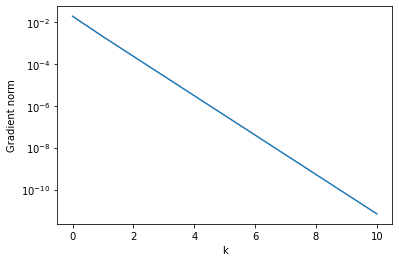

In [17]:
plt.plot(resids)
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("Gradient norm")

## Quasi-Newton methods

*Quasi-Newton* methods are Newton-like methods that build up an approximation of a Hessian over many iterations.  The most famous of these is the BFGS algorithm, which we will see in some examples later this week.  Methods like BFGS are particularly popular because they only require explicit gradients (not Hessians), but still can have the superlinear convergence seen with Newton.  Methods like limited-memory BFGS have the additional advantage that they use relatively cheap linear algebra operations (a dense factorization is not needed).

BFGS is a little more complicated than the algorithms we've coded so far, so we will use the implementation in
[SciPy's `optimize` package](https://docs.scipy.org/doc/scipy/reference/optimize.html).

      fun: -1.9132229549810362
 hess_inv: array([[0.41425732, 0.16324185],
       [0.16324185, 0.41406294]])
      jac: array([-2.37064497e-08,  1.90795255e-08])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([-0.54719756, -1.54719755])


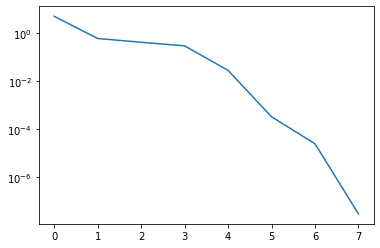

In [18]:
x0 = np.array([-1.0, 1.0])
xs = []
x = scipy.optimize.minimize(phi_mccormick, x0, method='BFGS', jac=dphi_mccormick, 
                            callback=lambda x: xs.append(x))
print(x)
plt.plot([np.linalg.norm(dphi_mccormick(x)) for x in xs])
plt.yscale("log")

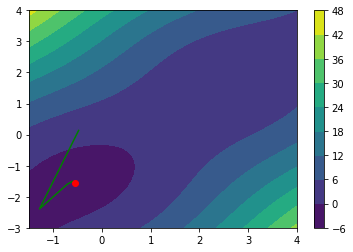

In [19]:
plot_mccormick()
plt.plot([x[0] for x in xs], [x[1] for x in xs], 'g')
plt.plot(xref_mccormick[0], xref_mccormick[1], 'ro')

## Line search

Many scaled gradient descent methods guarantee a descent direction, but one still needs to ensure that the step doesn't go too far.  We can illustrate with a one-dimensional example:
$$
  \phi(x) = x \tan^{-1}(x) - \frac{1}{2} \log(1+x^2).
$$ 
The first and second derivatives of $\phi$ are 
$$\begin{aligned}
  \phi'(x) &= \tan^{-1}(x) \\
  \phi''(x) &= \frac{1}{1+x^2}.
\end{aligned}$$ 
This is about as nice a problem as one could hope for.  It is convex, with a strong global minimizer at 0.  But what happens to Newton?

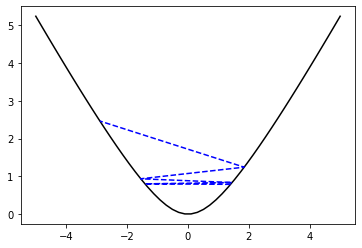

In [20]:
def phi_atan(x):
    "Test problem motivating line search"
    return x * np.arctan(x) - 0.5 * np.log(1 + x**2)

def dphi_atan(x):
    return np.arctan(x)

def Hphi_atan(x):
    return 1.0/(1+x**2)

x = 1.4
xs = []
for k in range(6):
    xs.append(x)
    x -= dphi_atan(x) / Hphi_atan(x)

xx = np.linspace(-5, 5)
plt.plot(xx, phi_atan(xx), 'k-', \
         xs, [phi_atan(x) for x in xs], 'b--')

In fact, the iteration will exponentially diverge for this problem for starting points greater than about 1.3917.
One can cook up equally benign-looking 1D functions for which Newton does other crazy things, as well, like converging to cycling between a pair of non-stationary points.

Dynamically changing the step size to ensure "sufficient progress" at every step us a simple approach that helps improve global convergence enormously.  The simplest such approach is a backtracking search that cuts the step length by a factor of two until one meets the condition
$$
  \phi(x_{k+1}) \leq \phi(x_k) - \alpha \eta \nabla \phi(x_k)^T M_k^{-1} \nabla \phi(x_k)
$$
for some $\eta < 1$ (typically a fairly small value is chosen).

Rejected step from 10 to -64.29194755233858, cut to s=0.5
Rejected step from 10 to -27.145973776169292, cut to s=0.25
Rejected step from 10 to -8.572986888084646, cut to s=0.125
Rejected step from -8.572986888084646 to 45.61084644776827, cut to s=0.5
Rejected step from -8.572986888084646 to 18.51892977984181, cut to s=0.25
Rejected step from -8.572986888084646 to 4.972971445878581, cut to s=0.125
Rejected step from 4.972971445878581 to -12.682690961232026, cut to s=0.5
Rejected step from 4.972971445878581 to -3.8548597576767225, cut to s=0.25
Rejected step from -3.8548597576767225 to 6.588741571651559, cut to s=0.5
Rejected step from -3.8548597576767225 to 1.366940906987418, cut to s=0.25


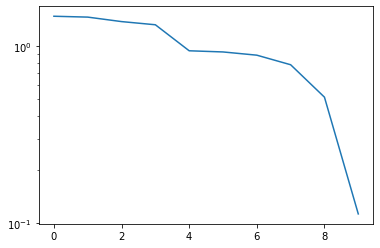

In [21]:
x = 10
xs = []
phi_x = phi_atan(x)
for k in range(10):
    xs.append(x)
    p = -dphi_atan(x) / Hphi_atan(x)
    s = 1.0
    while phi_atan(x+s*p) > phi_x + s * 1e-2 * dphi_atan(x) * p and s > 1e-3:
        s /= 2.0
        print("Rejected step from {0} to {1}, cut to s={2}".format(x, x+s*p, s))
    x += s*p
    phi_x = phi_atan(x)

plt.plot([np.abs(dphi_atan(x)) for x in xs])
plt.yscale("log")

## Sensitivity and regularization

Suppose we replace a "true" objective $\phi$ by some approximation $\hat{\phi} = \phi + \delta \phi$.  Of course, the optimum function value can change by at most $\|\delta \phi\|_\infty = \sup_{x \in \Omega} |\delta \phi|$, but what about the location of the minimizer?  That is, if $x_*$ is a (local) minimizer for $\phi$, what can we say about the minimizer $\hat{x}_* = x_* + \delta x_*$ for $\delta \phi$?  Formally differentiating the stationary condition $\nabla \phi = 0$, we have:
$$
  H_{\phi}(x_*) \, \delta x_* + \nabla \delta \phi(x_*) = 0;
$$
that is, the first-order change in $x_*$ is $\delta x_* = -H_{\phi}(x_*)^{-1} \nabla \delta \phi(x_*)$.  Having just talked about Newton, you might recognize this as almost the same as a Newton step!  Thus, we expect the stationary point may be rather sensitive if the error function $\delta \phi$ has large gradients or if the Hessian is close to singular (or both!).

One usually ought to take some care when a minimizer is very sensitive, but the type of care depends on the type of problem.  If one is solving an optimization problem in order to estimate the parameters of some model for data, a sensitive optimum means that there are several solutions that fit the data about equally well, and we need some other way of figuring out which model is "best."  In this case, we usually consider add a *regularization* term.  In the case of a design problem, a very sensitive optimum may mean that there are several solutions that solve the design problem as posed at the same level, and we can ask for the solution that is best along some other axis -- minimizing cost for the same performance, for example.

## An aside on finite differences

I am prone to calculus errors, so I usually check myself by comparing to a finite difference approximation:
$$\begin{align}
  \nabla \phi(x)^T u &= \frac{\phi(x+hu)-\phi(x)}{h} + O(h) \\
  \nabla \phi(x)^T u &= \frac{\phi(x+hu)-\phi(x-hu)}{2h} + O(h^2).
\end{align}$$
This is great for testing, as checking in a few random directions $u$ usually gives me some confidence that my
derivatives are coded correctly.

Some also like to use finite differences to estimate derivatives used in optimization schemes.  This isn't a terrible idea, but it can be expensive in terms of function evaluations.  For example, to do a gradient estimate at a point $x$ using first-order finite differences requires $n+1$ function evaluations (the one at $x$ and one for each coordinate direction).  There are also some numerical subtleties: in real computations, $h$ has to be chosen to balance truncation error (which can be estimated by manipulating Taylor series) and error in computation of the function (due to roundoff or due to use of methods like Monte Carlo).

It's often worth doing the calculus by hand (or using symbolic tools like SymPy, or *automatic differentiation* as described earlier in the notebook).  Finite differencing needs to be done carefully if it is to be done at all.  Often, if derivatives are not available, it is worth considering a derivative-free method based on an interpolated polynomial model rather than using finite difference estimates.  We will talk about such derivative-free methods tomorrow.

Text(0, 0.5, "Relerr in fd approx of phi'(x)")

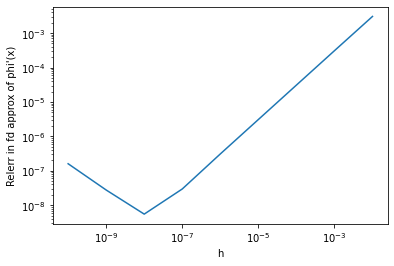

In [22]:
# Demo: Finite difference error vs h (fixed x) for log(x) cos(x)

def phi(x):
    return np.log(x) * np.cos(x)

def dphi(x):
    return -np.log(x) * np.sin(x) + np.cos(x)/x

def dphi_fd(x, h):
    "One-sided finite difference approx of phi'(x)"
    return (phi(x+h)-phi(x))/h

# Plot observed vs predicted relative error in finite diff vs h
hs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
plt.plot(hs, [np.abs(dphi_fd(2.0, h)/dphi(2.0)-1.0) for h in hs])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("h")
plt.ylabel("Relerr in fd approx of phi'(x)")

Text(0, 0.5, "Relerr in fd approx of phi'(x)")

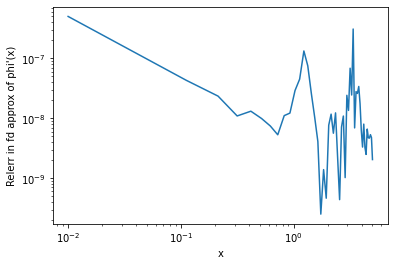

In [23]:
# Now plot observed predicted relative error in finite diff vs x for fixed h

xs = np.linspace(0.01, 5)
plt.plot(xs, [np.abs(dphi_fd(x, 1e-8)/dphi(x)-1.0) for x in xs])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("x")
plt.ylabel("Relerr in fd approx of phi'(x)")